# Time Series Analysis

In this notebook we will focus on studying the main time series components for each of the variables. The steps will be described below, but they will be repeated in each one of the variables. This analysis comes after the initial EDA done block by block, where we studied the different data fields and their distribution.

First of all, we will define some basic time series concepts (they are explained in natural language, for more information, refer to the complete thesis):
- **Stationarity**: a stationary time series is a time series where statistical properties do not change over time.
- **Time series decomposition**: when we consider a series as a combination of level, trend, seasonality and noise components, we can have an additive model or a multiplicative model.
- **Trend**: a trend component is the result of a varying mean over time.
- **Seasonality**: the seasonality component is a changing variance over time.
- **Differencing**: data transformation used to make a series stationary, it is performed by subtracting the previous observation from the current observation.
- **Lag difference**: the difference between consecutive observations is called a lag-1 difference.


In [2]:
# Basic imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy import signal

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import statsmodels.api as sm
import pymannkendall as mk

from pandas.plotting import autocorrelation_plot

path = "../data_postprocess/"
path_bruto = "../data/"

## Energy use 

We will study the following properties:
1. Trend detection
    - We will try detrending with multiple tools
2. Seasonality with multiple box plots and autocorrelation plots
    - Seasonal decomposition
3. Cyclical Variations
4. Possible decompositions


In [3]:
# Importamos csv
energy_use = pd.read_csv(path+'ele_postprocess.csv')
#We change the date column into datetime format
energy_use['date']= pd.to_datetime(energy_use['date'])
energy_use.set_index('date', inplace=True)
energy_use= energy_use.clip(lower=0.01)


The first variable we will study is 'mels_S' (miscellaneous energy use in the south wing of the building).

In [4]:
var = 'mels_S'

Text(0.5, 1.0, 'Energía utilizada en el ala sur')

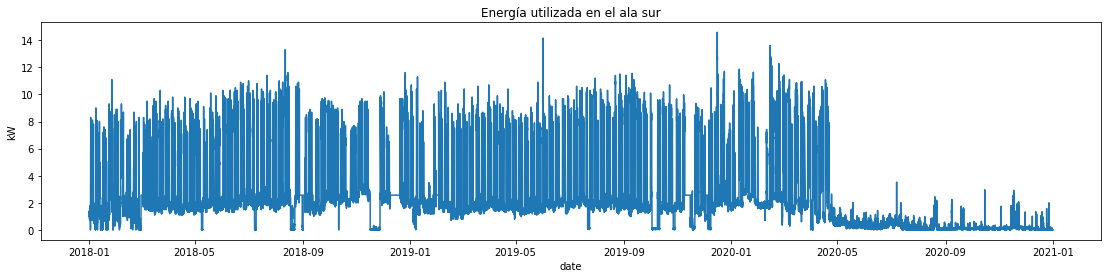

In [6]:
plt.figure(figsize=(19,4))
sns.lineplot(x =energy_use.index , y=energy_use[var])
plt.ylabel('kW')

plt.title('Energía utilizada en el ala sur')

Since we will initally only use data from May 2018 until February 2019 (period of time where occupant data is available), we are going to analyze the properties during that period of time:

In [7]:
start = '2018-05-22 07:00:00'
end = '2019-02-21 10:11:00'

In [8]:
occ = pd.read_csv(path+'occ_postprocess.csv')
occ.head(-1)

,date,occ_third_south,occ_fourth_south
0,2018-05-22 07:00:00,0.0,0.0
1,2018-05-22 07:01:00,0.0,1.0
2,2018-05-22 07:02:00,0.0,0.0
3,2018-05-22 07:03:00,0.0,1.0
4,2018-05-22 07:04:00,0.0,0.0
...,...,...,...
396187,2019-02-21 10:07:00,0.0,0.0
396188,2019-02-21 10:08:00,0.0,0.0
396189,2019-02-21 10:09:00,0.0,0.0
396190,2019-02-21 10:10:00,0.0,0.0


In [9]:
energy_use = energy_use[(energy_use.index>=start)&(energy_use.index<=end)]

### Trend detection

We will run two tests for trend detection:
- **Mann–Kendall trend test**: https://www.frontiersin.org/articles/10.3389/feart.2020.00014/full
- **Hodrick–Prescott filter**: https://eprints.whiterose.ac.uk/97954/1/HP_ACM.pdf

In [33]:
print(mk.original_test(energy_use[var], alpha=0.05))

KeyboardInterrupt: 

In [76]:
def plot_hpfilter(df, var, title):
    eu_cycle,eu_trend = hpfilter(df[var], lamb=1600) 
    eu_trend.plot(figsize=(15,6)).autoscale(axis='x',tight=True)
    plt.title(title)

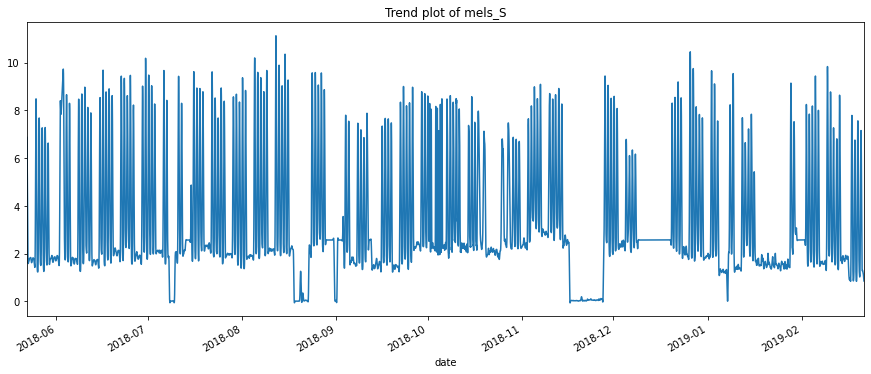

In [77]:
plot_hpfilter(energy_use, var, 'Trend plot of mels_S')

We don't really see a very clear trend, however, there is some seasonal pattern in the years 2018 and 2019. The last year (2020) is completely different, which makes sense since the use of the building decreased due to the pandemic.

#### Detrending

Even if we don't really have a clear trend, we want to check these tools and see if there are some subtrends that we didn't catch in our first analysis.(Mathematical explanation in https://link.springer.com/content/pdf/10.1007/978-1-4419-0320-4.pdf)


In [78]:
def plot_detrends(df, var):

    fig, axes = plt.subplots(nrows=3,ncols=1, figsize=(10,10) )
    diff = df[var].diff()

    axes[0].plot(diff)
    axes[0].set_title('Detrending using Differencing', fontsize=12) 
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel(var)


    detrended = signal.detrend(df[var].values)
    axes[1].plot(detrended)
    axes[1].set_title('Detrending using Scipy Signal', fontsize=12) 
    axes[1].set_xlabel(var)
    axes[1].set_ylabel('Frequency')

    eu_cycle,eu_trend = hpfilter(df[var], lamb=1600)
    detrended = df[var]-eu_trend
    axes[2].plot(detrended)
    axes[2].set_title('Detrending using HP Filter', fontsize=12) 
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel(var)
    plt.suptitle('Detrending: '+ var, fontsize=16)
    plt.tight_layout()

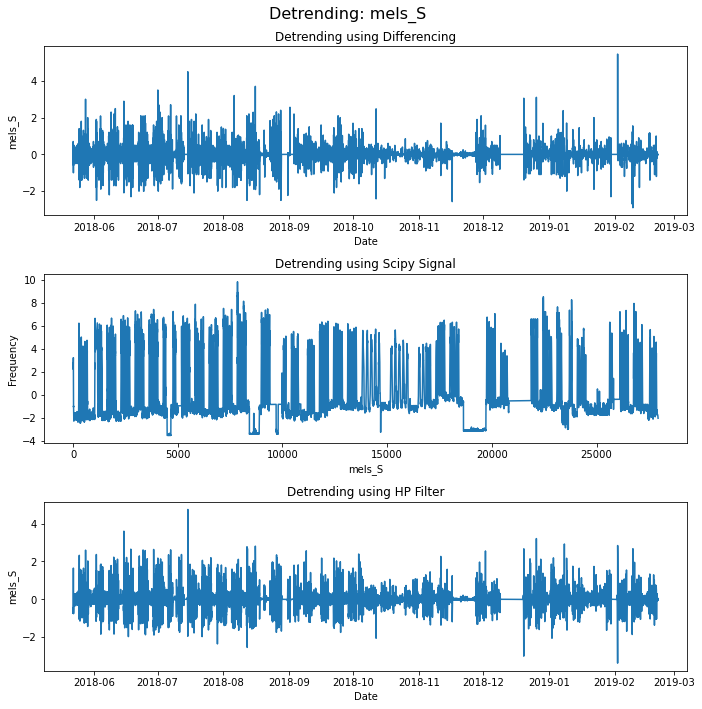

In [79]:
plot_detrends(energy_use, var)

## Seasonality 

We will study seasonality with Multiple Box Plots and Autocorrelation Plots:

### Multiple Box Plots

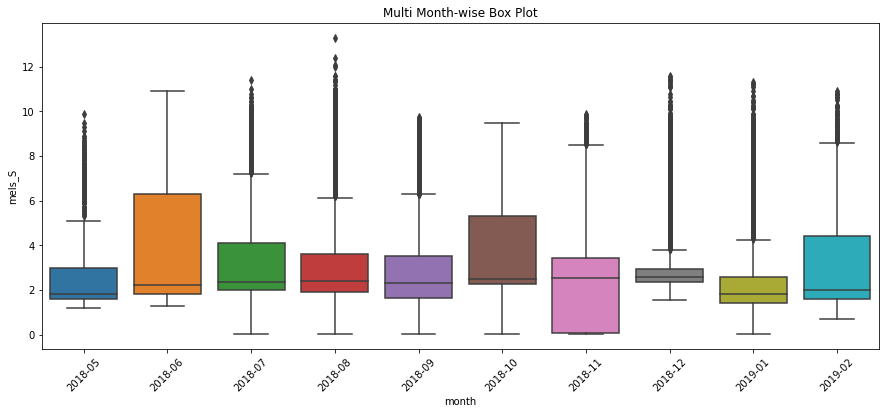

In [80]:
energy_use['month'] = energy_use.index.to_period("M")
plt.figure(figsize=(15,6))
sns.boxplot(x='month', y=var, data=energy_use)
plt.title("Multi Month-wise Box Plot")
plt.xticks(rotation=45)
plt.show()

We don't see a seasonal pattern in the box plot, we will try to plot it again with detrended time series, using differencing:



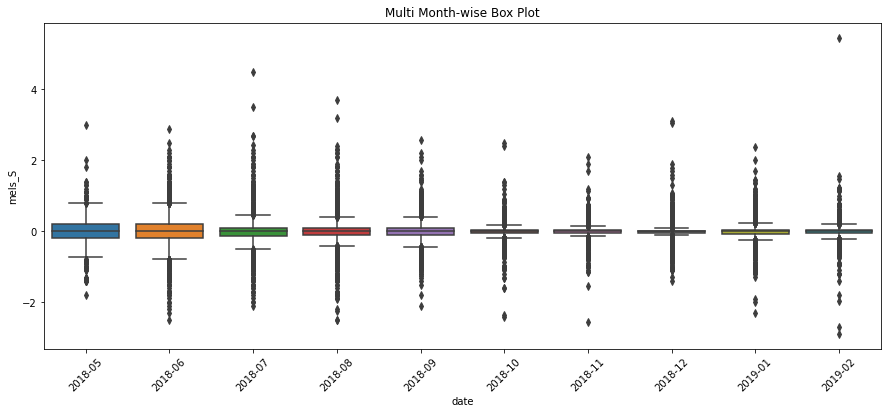

In [81]:
diff = energy_use[var].diff()
months = diff.index.to_period("M")
diff.columns = [var, 'month']
plt.figure(figsize=(15,6))
sns.boxplot(x=months, y=diff)
plt.title("Multi Month-wise Box Plot")
plt.xticks(rotation=45)
plt.show()

Detrending didn't show any seasonality either.

### Autocorrelation and partial autocorrelation plots

Mathematical explanation of autocorrelation plots: https://www.itl.nist.gov/div898/handbook/eda/section3/autocopl.htm



<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

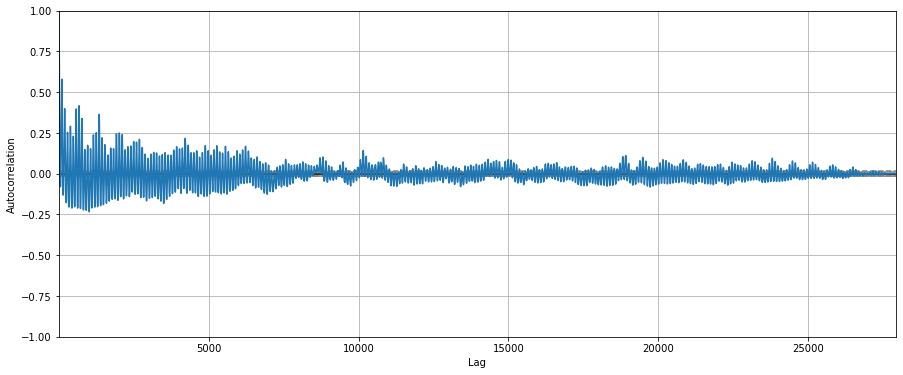

In [82]:
plt.figure(figsize=(15,6))
autocorrelation_plot(energy_use[var].tolist())

(0.0, 7000.0)

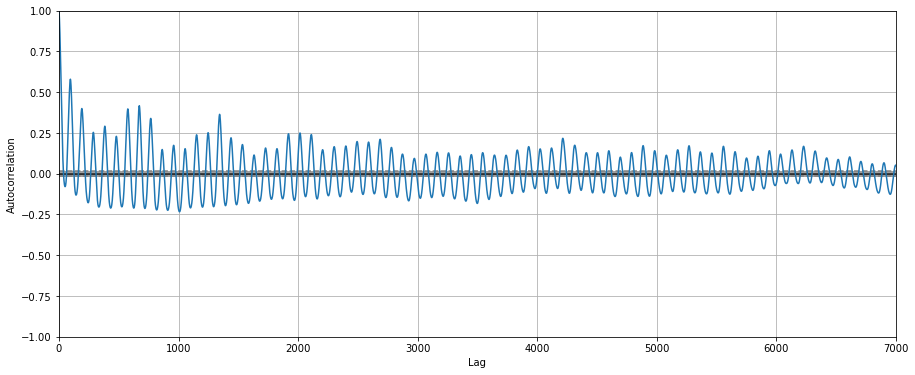

In [83]:
plt.figure(figsize=(15,6))

autocorrelation_plot(energy_use[var].tolist()).set_xlim([0,7000])

We can see that the initial autocorrelation plot didn't really show any seasonality, but once we "zoom in" (we change the lag in the x axis), we can clearly see some pattern. One reason for this could be that when we reduce the lag we are checking the pattern day by day, instead of a generic pattern, so clearly the correlation between measures at the same time of different days is going to be higher than the one between random measures in different days of the three years.


We check another way of plotting the same thing:




<Figure size 1080x432 with 0 Axes>

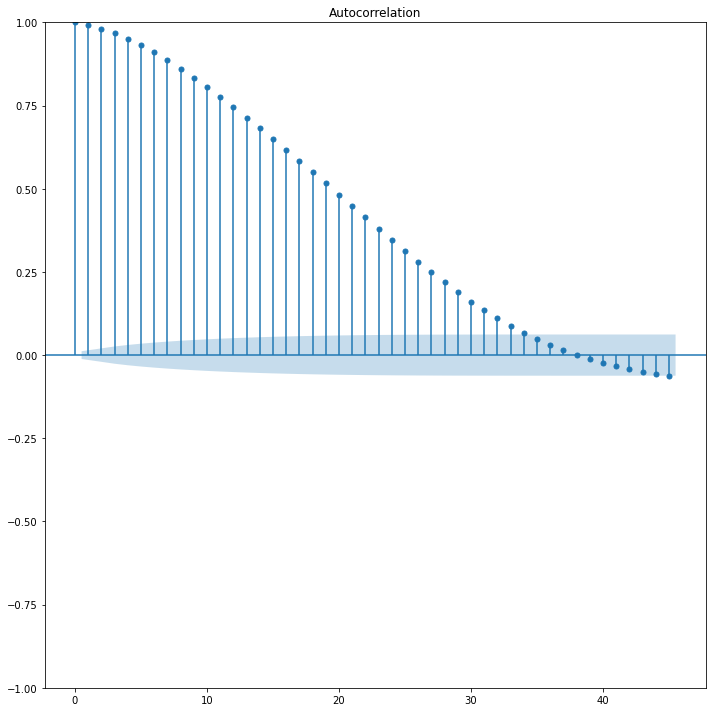

In [61]:
plt.figure(figsize=(15,6))
fig=plot_acf(energy_use[var])
fig.set_figheight(10)
fig.set_figwidth(10)
fig.tight_layout()
plt.show()

<Figure size 1080x432 with 0 Axes>

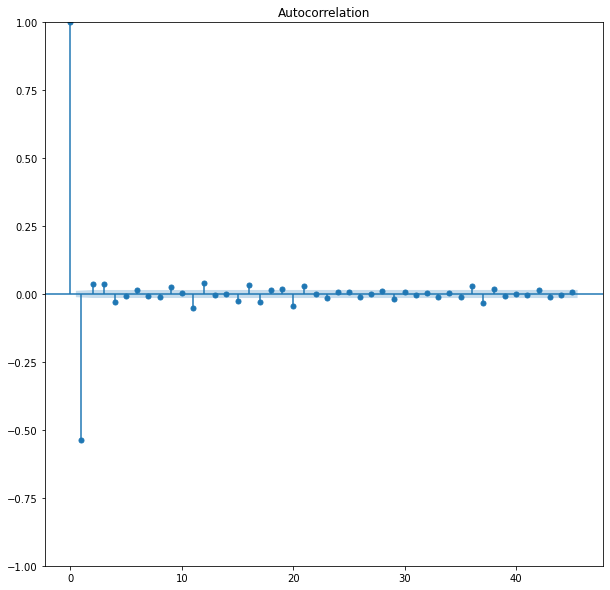

In [64]:
#We also plot the autocorrelation plot of the differenced time series:

fig =plt.figure(figsize=(15,6))
fig=plot_acf(energy_use[var].diff().diff().dropna())
fig.set_figheight(10)
fig.set_figwidth(10)
plt.show()

#### Partial Autocorrelation Plots

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

<Figure size 1080x432 with 0 Axes>

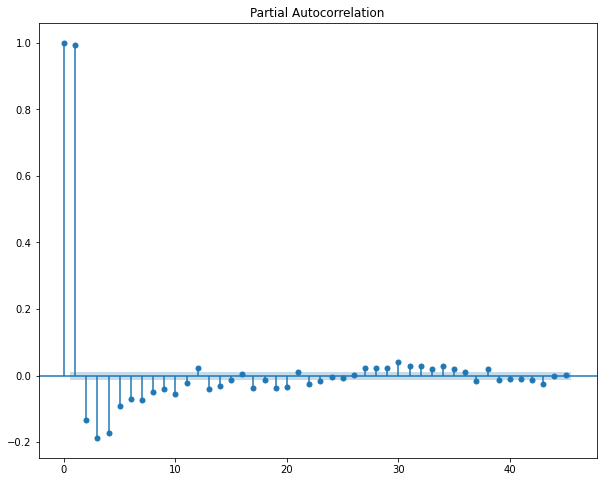

In [85]:
plt.figure(figsize=(1,6))

plot_pacf(energy_use[var],method='ols' ) #Probar varios métodos
plt.show()

#### Seasonal decomposition

We can use seasonal decomposition to remove seasonality from data and check the data only with the trend, cyclic, and irregular variations.

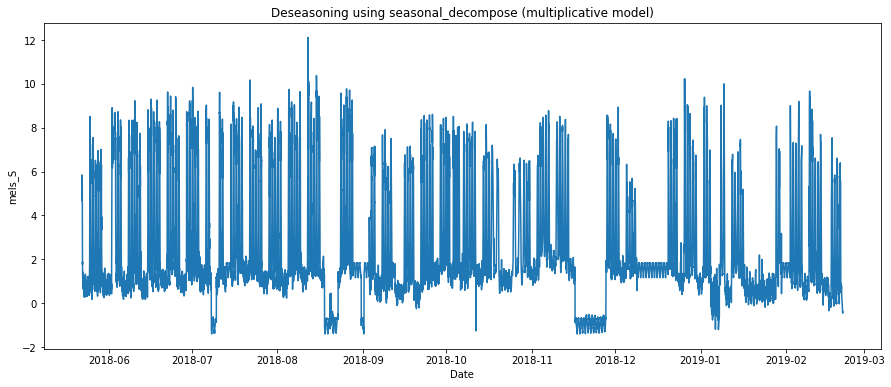

In [100]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_seasonal_decompose(df, var, model, period):
    result_mul = seasonal_decompose(df[var], model=model, period = period)
    deseason = df[var] - result_mul.seasonal
    plt.figure(figsize=(15,6))
    plt.plot(deseason)
    plt.title('Deseasoning using seasonal_decompose (' +model+ ' model)', fontsize=12) 
    plt.xlabel('Date')
    plt.ylabel(var)
    plt.show()

plot_seasonal_decompose(energy_use, var, 'multiplicative', 96)

In [122]:

def plot_seasonal(df, var, model, period):
    result_mul = seasonal_decompose(df[var], model=model, period = period)
    res = result_mul.seasonal[result_mul.seasonal.index.month.isin([5,6,7,8])]
    plt.figure(figsize=(15,6))
    plt.plot(res)
    plt.title('seasonal_decompose (' +model+ ' model)', fontsize=12) 
    plt.xlabel('Date')
    plt.ylabel(var)
    plt.show()

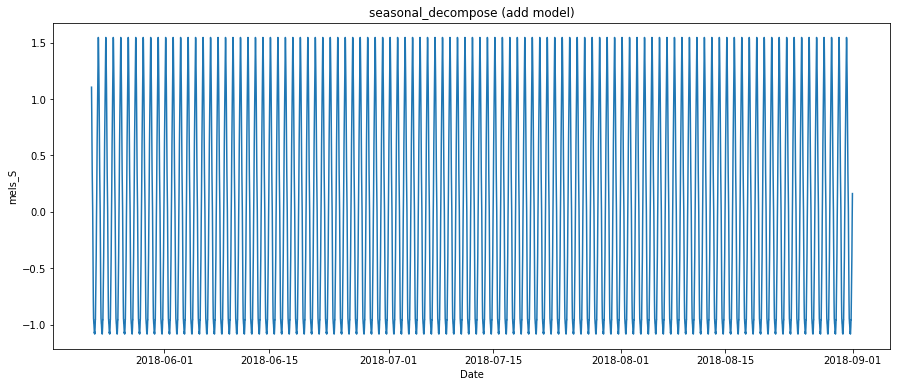

In [124]:
plot_seasonal(energy_use, var, 'add', 96)

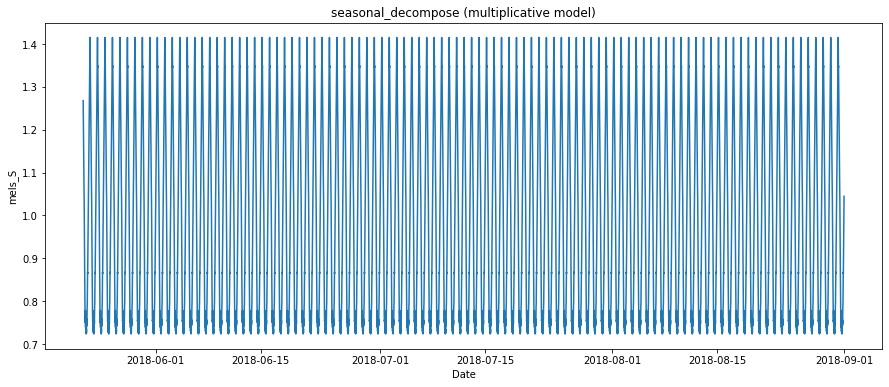

In [125]:
plot_seasonal(energy_use, var, 'multiplicative', 96)

## Cyclical Components
Cyclical components are fluctuations around a long trend observed every few units of time. We will use one more time the HP Filter to detect them:

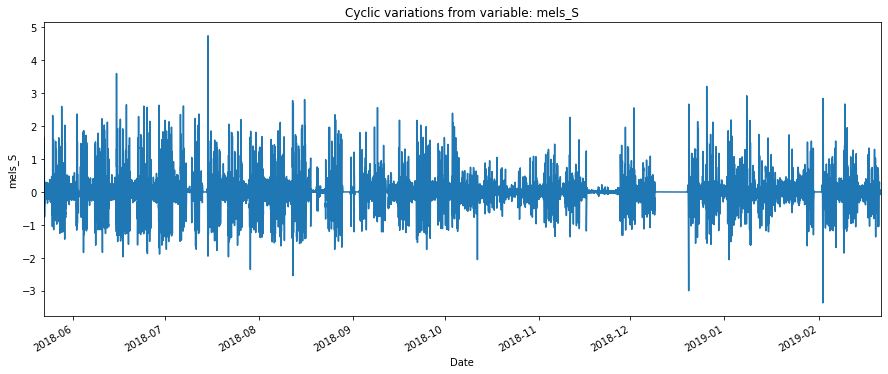

In [88]:
def plot_hpfilter2(df, var, title):
    eu_cycle,eu_trend = hpfilter(df[var], lamb=1600) 
    eu_cycle.plot(figsize=(15,6)).autoscale(axis='x',tight=True)
    plt.xlabel('Date')
    plt.ylabel(var)  
    plt.title(title)
plot_hpfilter2(energy_use, var, 'Cyclic variations from variable: ' + var)

## Decomposition of time series



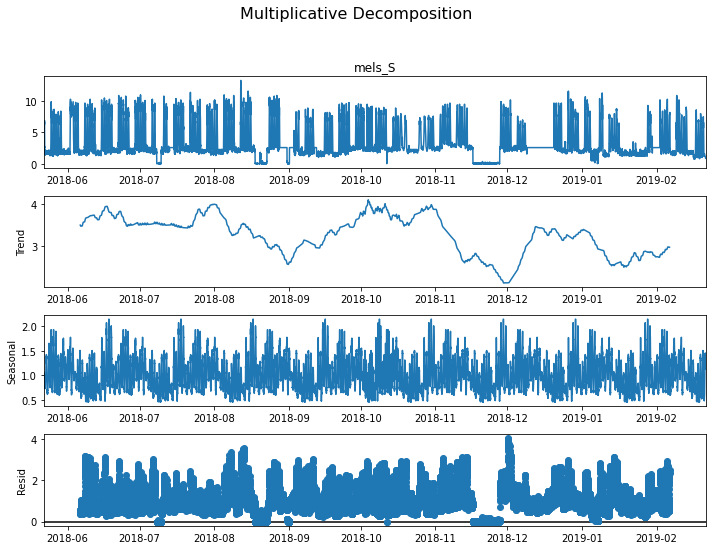

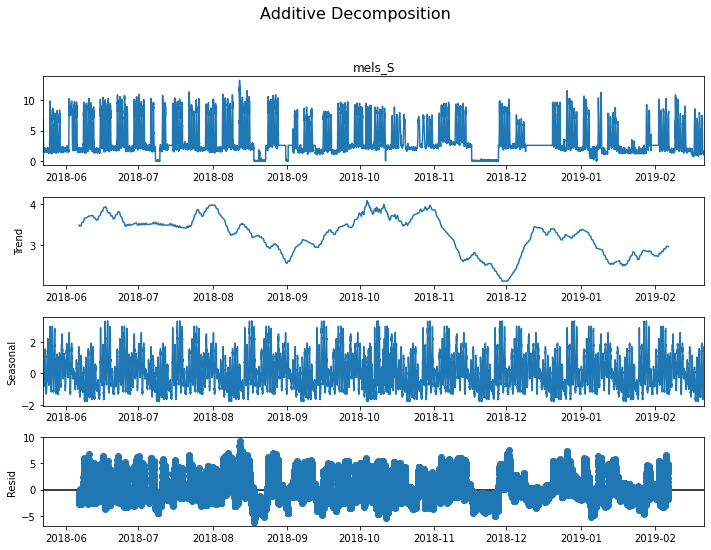

In [92]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

def mostrar_descomp(df, variable, period):
    # Multiplicative Decomposition 
    multiplicative_decomposition = seasonal_decompose(df[variable], model='multiplicative', period = period)

    # Additive Decomposition
    additive_decomposition = seasonal_decompose(df[variable], model='add', period = period)

    # Plot
    plt.rcParams.update({'figure.figsize': (10,8)})
    multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()


#Monthly period (means that the cycle of seasonality is a month)
mostrar_descomp(energy_use, var, 2880)

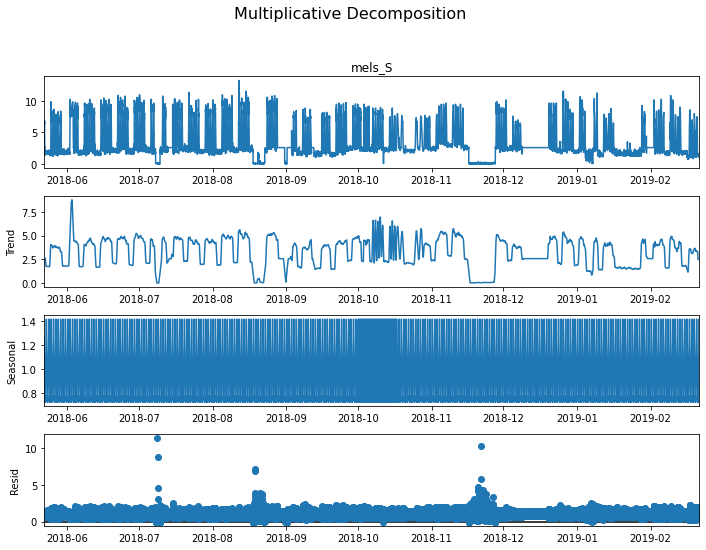

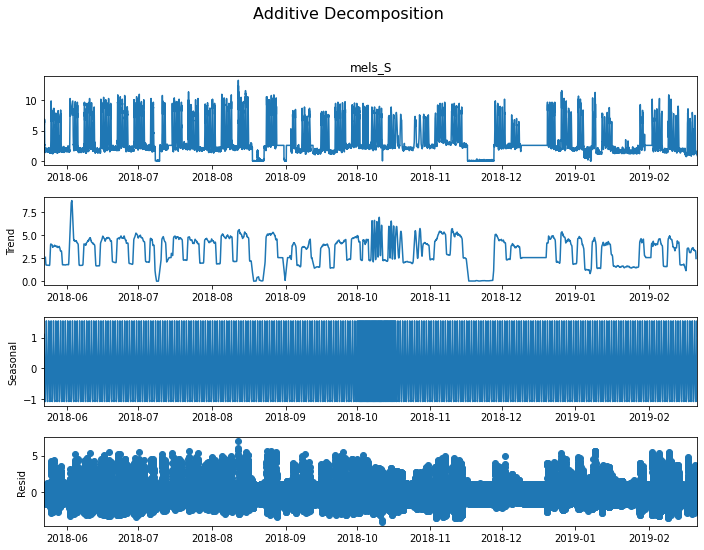

In [94]:
#Daily period (means that the cycle of seasonality is a day)
mostrar_descomp(energy_use, var, 96)

### Rolling Statistics plot

We are going to plot the rolling mean and standard deviation of the time series, with a window of a week (672 rows)

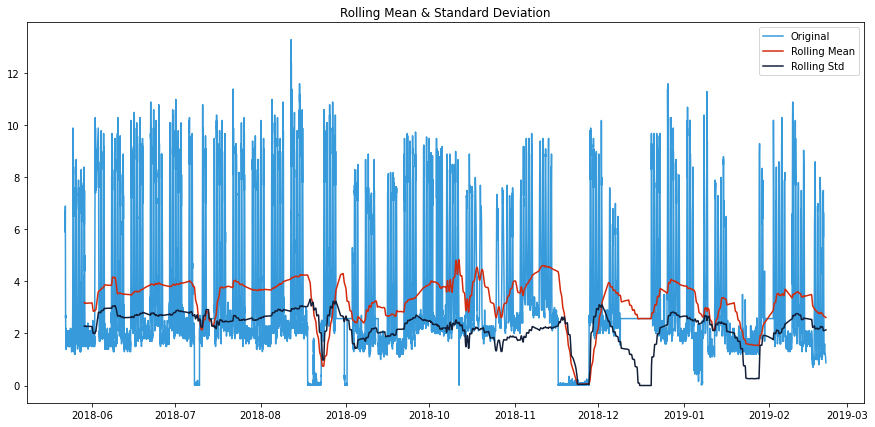

In [28]:
def plot_rolling_stats(series):

    #Determine rolling statistics
    rolling_avg = series.rolling(window=672).mean() 
    rolling_std = series.rolling(window=672).std() 

    #Plot rolling statistics
    plt.figure(figsize=(15,7))
    plt.plot(series, color='#379BDB', label='Original')
    plt.plot(rolling_avg, color='#D22A0D', label='Rolling Mean')
    plt.plot(rolling_std, color='#142039', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


plot_rolling_stats(energy_use[var])

### Dickey Fuller Test for stationarity

Finally, we will run the dickey fuller (https://atsa-es.github.io/atsa-labs/sec-boxjenkins-aug-dickey-fuller.html) test on this variable

In [13]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(energy_use[var], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -18.99026748267132
n_lags: 0.0
p-value: 0.0
Critial Values:
   1%, -3.4305844471001494
Critial Values:
   5%, -2.8616436189939036
Critial Values:
   10%, -2.566825153278331


Since the p-value is lower than 0.5, we can reject the null hypothesis: the time series is non stationary, this means that the time series is stationary.

We will now repeat the test with the differenced time series:

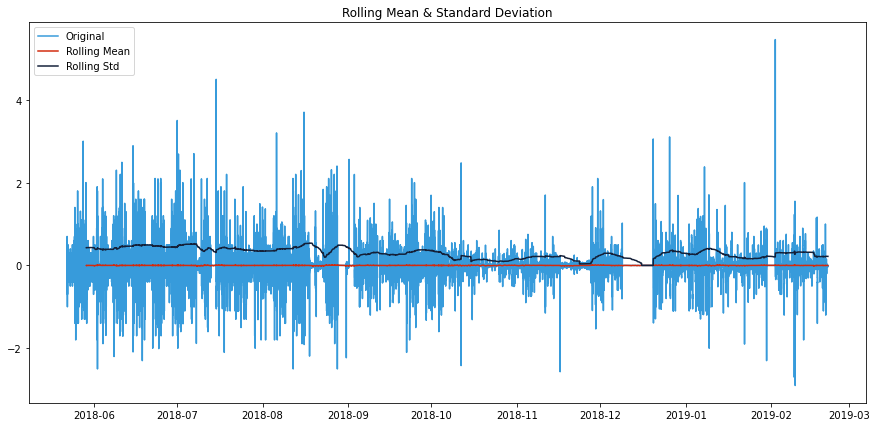

In [32]:
plot_rolling_stats(energy_use[var].diff())

In [66]:
result = adfuller(energy_use[var].diff().dropna(), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  


ADF Statistic: -31.397222690748666
n_lags: 0.0
p-value: 0.0
Critial Values:
   1%, -3.4305845227731817
Critial Values:
   5%, -2.861643652437924
Critial Values:
   10%, -2.5668251710798087


The result is the same, but in the plot we can see that the stationarity of the time series is much more evident in the differenced one.

### Dummy model 

We will fit a very basic ARIMA model into this variable, and we will study its behaviour. Since we have seasonality in our data, we will also use SARIMA and compare the results of fitting both models.

#### ARIMA

For this model, we have to decide the value of the main parameters:
- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.



In [78]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import TimeSeriesSplit


We will use a grid of parameters to obtain a correct combination of them.

In [83]:
def evaluate_model(X, order):
    tscv = TimeSeriesSplit()
    error = 0
    for train_index, test_index in tscv.split(X):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        history = [x for x in X_train]
        # make predictions
        predictions = list()
        for t in range(len(X_test)):
            model = ARIMA(history, order=order)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(X_test[t])
        # calculate out of sample error
        error_p = mean_squared_error(X_test, predictions)
        print("MSE: ", error_p)
        error += error_p
    error/=5
    print("MSE in 5 splits: ", error)
        
    

In [84]:
evaluate_model(energy_use[var], (1,2,2))

TRAIN: [   0    1    2 ... 4655 4656 4657] TEST: [4658 4659 4660 ... 9311 9312 9313]


/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE:  0.16666428284859947
TRAIN: [   0    1    2 ... 9311 9312 9313] TEST: [ 9314  9315  9316 ... 13967 13968 13969]


/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE:  0.08273629289895598
TRAIN: [    0     1     2 ... 13967 13968 13969] TEST: [13970 13971 13972 ... 18623 18624 18625]


/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/maguado/opt/anaconda3/lib/python3.9/s

KeyboardInterrupt: 